# Future Network Constrained Linear Optimal Power Flow

PyPSA-GB can model the GB power system  by solving a network constrained Linear Optimal Power Flow (LOPF) problem. This notebook shows the example application of a future 3 day period.

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import pypsa
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.style.use('ggplot')
import pandas as pd
import cartopy.crs as ccrs

import data_reader_writer

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [3]:
# write csv files for import
start = '2040-02-28 00:00:00'
end = '2040-03-01 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour
time_step = 1.

Choose from one of the National Grid Future Energy Scenarios.

In [4]:
# scenario = 'Leading The Way'
scenario = 'Consumer Transformation'
# scenario = 'System Transformation'
# scenario = 'Steady Progression'

Choose a baseline year (from 2010-2020). The baseline year determines which historical load profile and weather dataset is used for the future year modelled. The National Grid FES modellers used 2012 as their baseline year.

In [5]:
year_baseline = 2012

data_reader_writer is a script written to read in data from the various sources and write csv files in the format required for populating a PyPSA network object

In [6]:
data_reader_writer.data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=year_baseline,
                               scenario=scenario, FES=2022, merge_generators=True, scale_to_peak=True,
                               networkmodel='Zonal', marine_modify=True, marine_scenario='Mid', P2G=False)

C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:206: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_FES = df_FES[~df_FES.Variable.str.contains('(TWh)')]
c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:206: UserWarning: This pattern has match groups. To act

In [7]:
network = pypsa.Network()

network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network LOPF_data has buses, generators, links, loads, storage_units


Links need to be scaled up to accomadate for future generation.

In [8]:
contingency_factor = 4
network.lines.s_max_pu *= contingency_factor

In [9]:
network.consistency_check()

Index(['Tidal lagoon Z6'], dtype='object', name='Generator')
Index(['build_year'], dtype='object', name='attribute')
They are:
attribute
build_year    int64
dtype: object
but should be:
attribute
build_year    int32
Name: dtype, dtype: object
Index(['build_year'], dtype='object', name='attribute')
They are:
attribute
build_year    int64
dtype: object
but should be:
attribute
build_year    int32
Name: dtype, dtype: object
Index(['build_year', 'min_up_time', 'min_down_time', 'up_time_before',
       'down_time_before'],
      dtype='object', name='attribute')
They are:
attribute
build_year          int64
min_up_time         int64
min_down_time       int64
up_time_before      int64
down_time_before    int64
dtype: object
but should be:
attribute
build_year          int32
min_up_time         int32
min_down_time       int32
up_time_before      int32
down_time_before    int32
Name: dtype, dtype: object


## Running the optimisation

In [10]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.62s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19
Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-9ojxtoj4.lp
Reading time = 0.30 seconds
obj: 160016 rows, 47089 columns, 276480 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 160016 rows, 47089 columns and 276480 nonzeros
Model fingerprint: 0x7f253c5b
Coefficient statistics:
  Matrix range     [7e-01, 1e+00]
  Objective range  [1e+00, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+09]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 153542 rows and 24201 columns
Presolve time: 0.11s
Presolved: 6474 rows, 23314 columns, 40158 nonzeros

Ordering time: 0.04s

Barrier statistics:
 AA' NZ     : 1.266e+04
 Factor NZ  : 1.784e+05 (roughly 13 MB of memory)
 Factor Ops : 1.015e+07 (less tha

INFO:pypsa.linopf:Optimization successful. Objective value: 3.64e+13


('ok', 'optimal')

## Power output by generation type

Group the generators by the carrier, and print their summed power outputs over the simulation period.

In [11]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

print(network.links_t.p0)
imp = network.links_t.p0.copy()
imp[imp < 0] = 0
imp['Interconnectors Import'] = imp.sum(axis=1)
interconnector_import = imp[['Interconnectors Import']]
print(interconnector_import)

p_by_carrier = pd.concat([p_by_carrier, interconnector_import], axis=1)

exp = network.links_t.p0.copy()
exp[exp > 0] = 0
exp['Interconnectors Export'] = exp.sum(axis=1)
interconnector_export = exp[['Interconnectors Export']]
print(interconnector_export)

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

p_by_carrier

Link                 BritNed  EastWest  Moyle  Nemo     IFA         IFA2  \
snapshot                                                                   
2040-02-28 00:00:00      0.0       0.0    0.0   0.0 -2720.0  1360.000000   
2040-02-28 01:00:00      0.0       0.0    0.0   0.0  2720.0  1018.523370   
2040-02-28 02:00:00      0.0       0.0    0.0   0.0  -544.0  1070.098819   
2040-02-28 03:00:00      0.0       0.0    0.0   0.0 -2720.0  1360.000000   
2040-02-28 04:00:00      0.0       0.0    0.0   0.0 -2720.0   230.865969   
...                      ...       ...    ...   ...     ...          ...   
2040-03-01 19:00:00      0.0       0.0    0.0   0.0 -2720.0  1360.000000   
2040-03-01 20:00:00      0.0       0.0    0.0   0.0  -544.0  1360.000000   
2040-03-01 21:00:00      0.0       0.0    0.0   0.0   544.0  1360.000000   
2040-03-01 22:00:00      0.0       0.0    0.0   0.0  2720.0  1360.000000   
2040-03-01 23:00:00      0.0       0.0    0.0   0.0  2720.0  1360.000000   

Link       

,Biomass (co-firing),Biomass (dedicated),CCS Biomass,CCS Gas,Coal,Hydrogen,Hydro,Natural Gas,Nuclear,Oil,...,Waste,Wave power,Wind Offshore,Wind Onshore,Battery,Compressed Air,Liquid Air,Pumped Storage Hydroelectric,Interconnectors Import,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,,
2040-02-28 00:00:00,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,202.621410,0.000000,5565.103558,0.0,...,0.0,74.95137,30898.964690,11082.312727,2127.497694,0.000000,0.000000,0.000000,14286.053393,0.000000
2040-02-28 01:00:00,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,167.169830,0.000000,5760.932677,0.0,...,0.0,106.54337,31331.000284,9921.700038,0.000000,0.000000,0.000000,0.000000,15938.484969,0.000000
2040-02-28 02:00:00,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,170.934147,0.000000,6048.493837,0.0,...,0.0,130.74337,28817.146078,9878.519130,0.000000,0.000000,113.258072,0.000000,14172.303761,0.000000
2040-02-28 03:00:00,5.8765,550.442396,0.000000,0.000000,0.0,0.000000,159.098097,0.000000,6309.070435,0.0,...,0.0,103.85937,28985.691872,9130.075247,352.673301,0.000000,0.000000,0.000000,14905.391307,556.318896
2040-02-28 04:00:00,5.8765,347.877915,0.000000,0.000000,0.0,941.548928,18.612743,0.000000,6433.389224,0.0,...,0.0,103.85937,28023.707590,8567.952088,248.125381,0.000000,0.000000,0.000000,12965.420756,353.754415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040-03-01 19:00:00,114.1720,7339.247450,4188.102139,12657.089997,0.0,10603.510532,689.812023,5023.130000,8862.199999,0.0,...,0.0,458.18850,11934.983168,3071.767585,7336.521187,2881.350551,1496.348318,3706.927027,30236.412410,7453.419450
2040-03-01 20:00:00,114.1720,7090.518764,4034.108230,11270.800075,0.0,10603.510532,684.837417,4097.914574,8862.199999,0.0,...,0.0,503.65150,10812.672346,2683.941667,9556.324792,2802.640000,1954.314369,3706.927027,25560.517042,7204.690764
2040-03-01 21:00:00,114.1720,7513.679197,4034.108230,11973.087094,0.0,10603.510532,603.032788,4010.890000,8862.199999,0.0,...,0.0,541.61626,8852.319117,2112.238285,2475.227893,1409.054959,314.103045,3706.927027,22888.746133,7627.851197


Graph the power output of the different generation types...

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

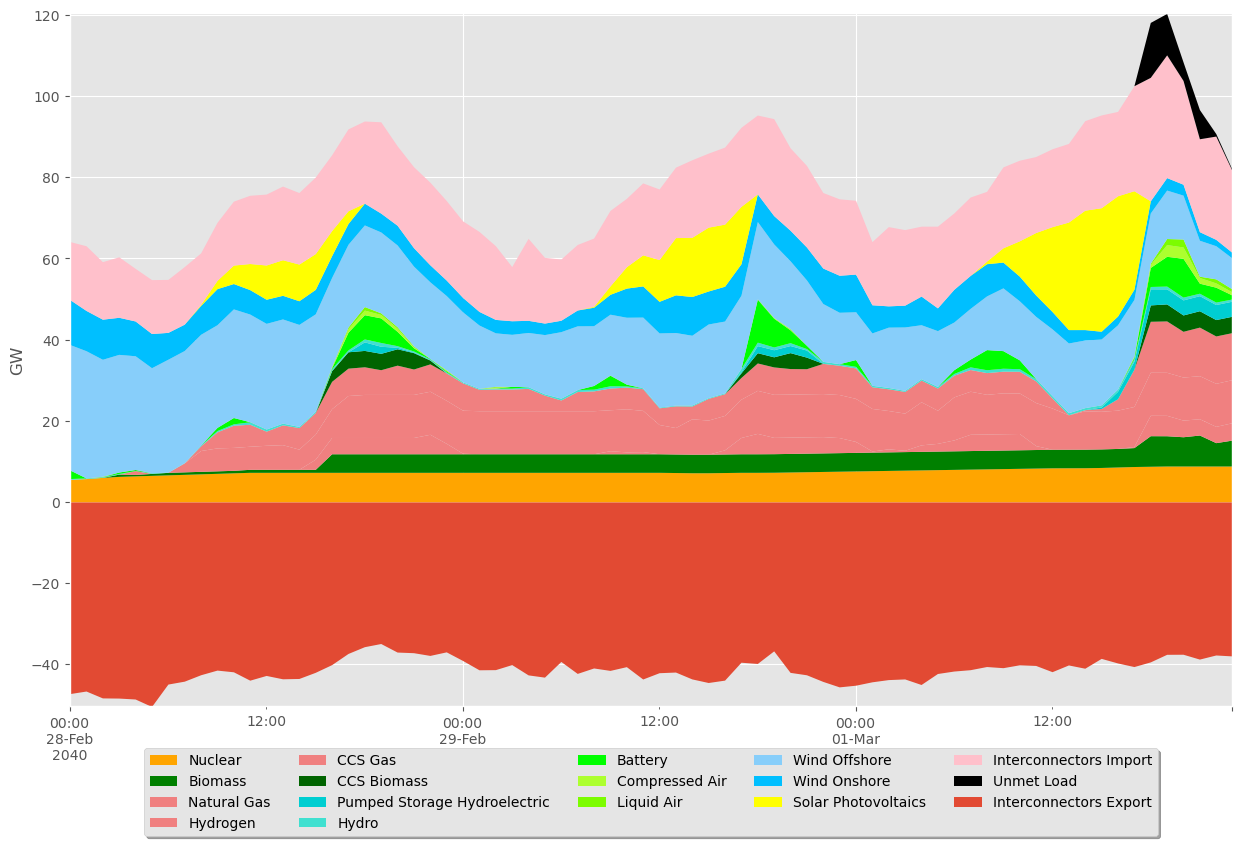

In [12]:
cols = ["Nuclear", 'Biomass',
        'Waste', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Interconnectors Import', 'Unmet Load'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

## Plotting storage

Graph the pumped hydro dispatch and state of charge...

Text(0.5, 0, '')

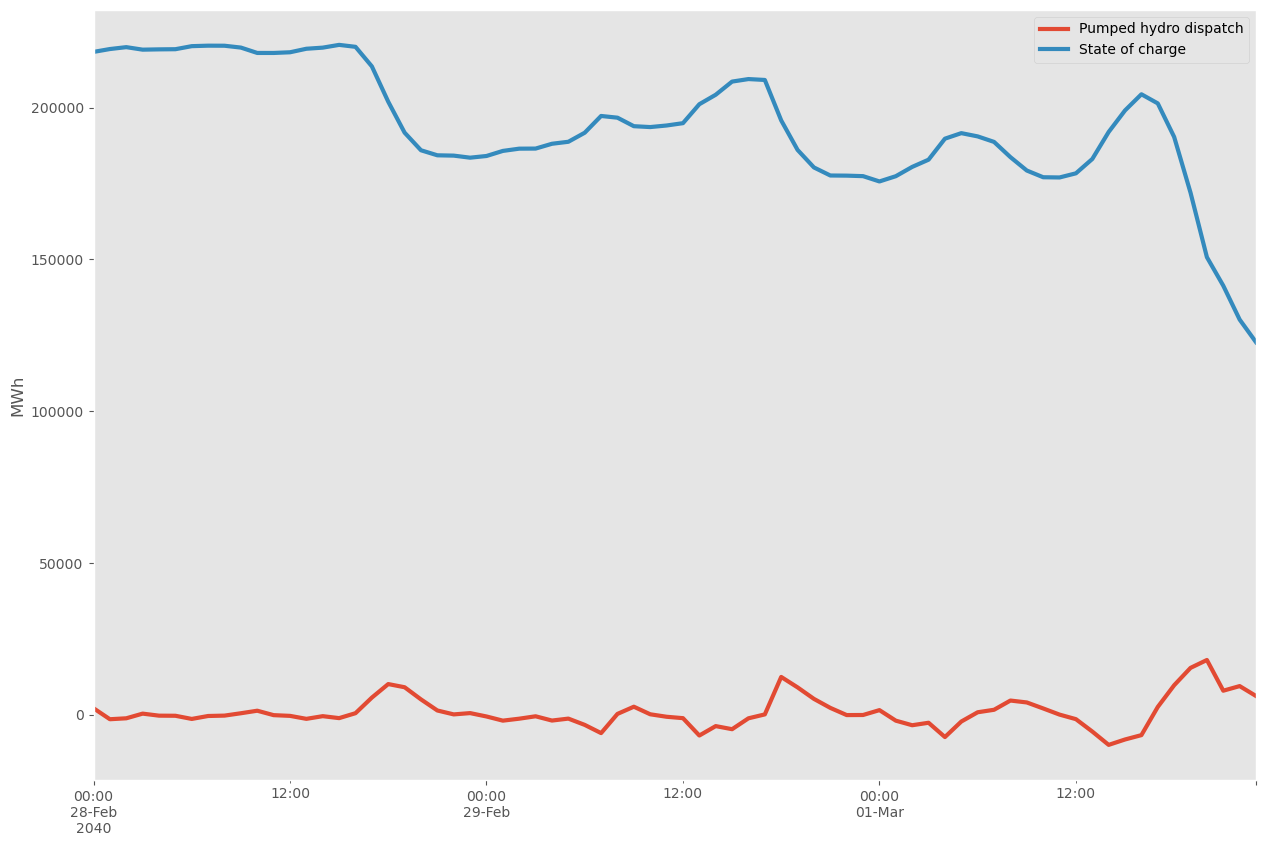

In [13]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage = network.storage_units_t.p.sum(axis=1)
state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="Pumped hydro dispatch", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")

## Plotting line loading

Look at the line loading stats and graph...

In [14]:
now = network.snapshots[60]

print("With the linear load flow, there is the following per unit loading:")
loading = network.lines_t.p0.loc[now] / network.lines.s_nom
loading.describe()

With the linear load flow, there is the following per unit loading:


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

(<matplotlib.collections.PatchCollection at 0x1fe32e51340>,
 <matplotlib.collections.LineCollection at 0x1fe33534ca0>)

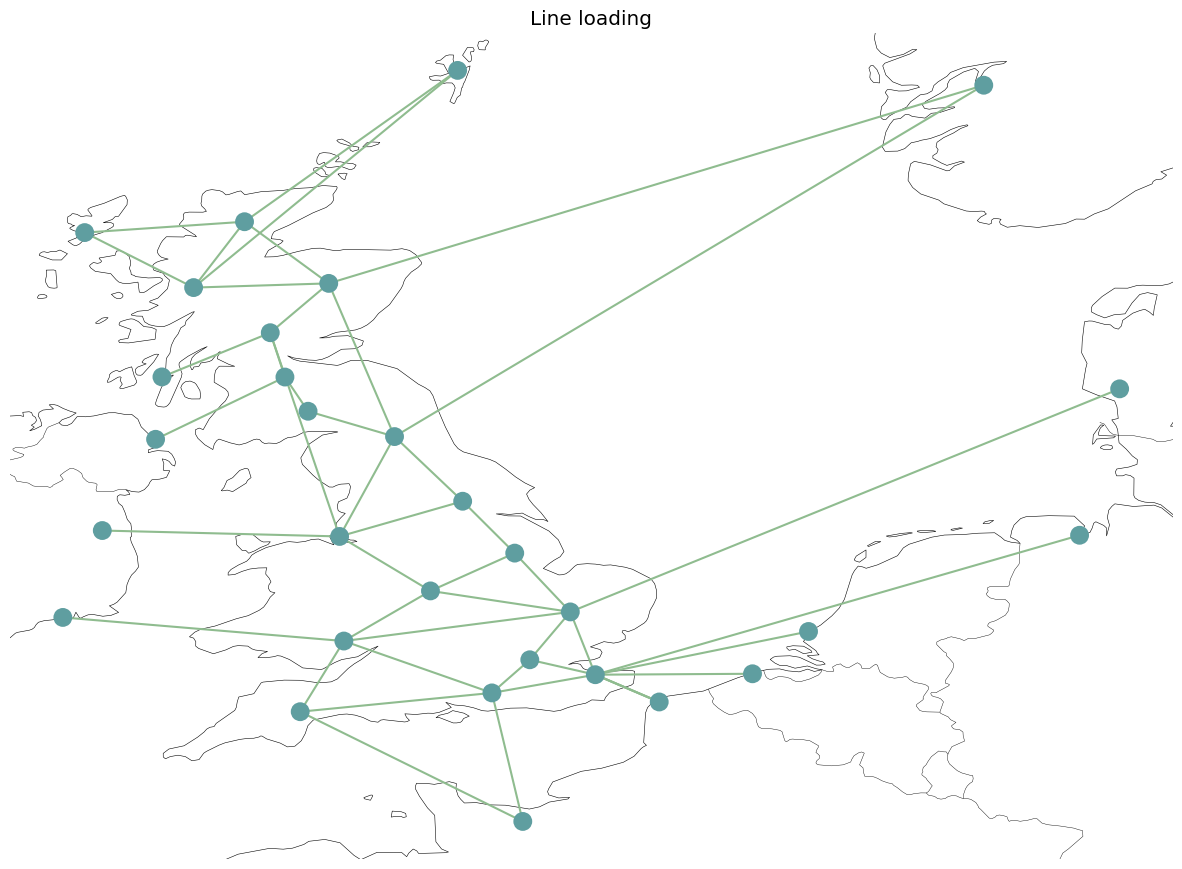

In [15]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(15, 17)

network.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading")

## Plotting locational marginal prices

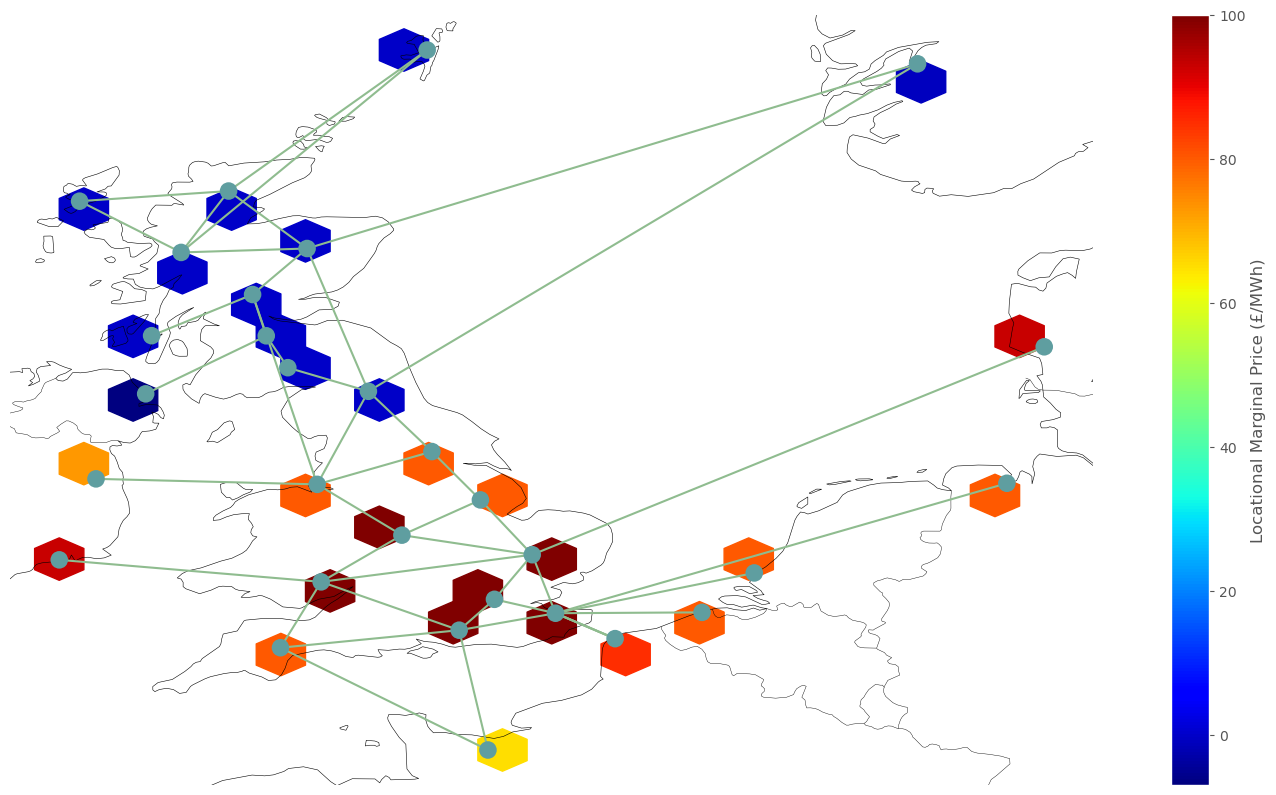

In [16]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index))
plt.hexbin(network.buses.x, network.buses.y,
           gridsize=20,
           C=network.buses_t.marginal_price.loc[now],
           cmap=plt.cm.jet)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (£/MWh)')

In [17]:
network.buses_t.marginal_price

Bus,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,Z1_1,Z1_2,...,Netherlands,Belgium,France1,France2,Ireland,N. Ireland,Ireland2,Germany,Norway,Denmark
snapshot,,,,,,,,,,,,,,,,,,,,,
2040-02-28 00:00:00,0.0,0.000000e+00,0.000000e+00,5.540168e+00,5.540168e+00,0.0,5.540168e+00,5.540168,0.0,0.0,...,-20.0,-20.0,-15.0,-9.459832,-7.0,-7.0,-1.459832e+00,-20.0,-1.0,-7.000000e+00
2040-02-28 01:00:00,0.0,0.000000e+00,0.000000e+00,5.000000e+00,5.000000e+00,0.0,5.000000e+00,5.000000,0.0,0.0,...,-20.0,-20.0,-15.0,-10.000000,-7.0,-7.0,-2.000000e+00,-20.0,-1.0,-7.000000e+00
2040-02-28 02:00:00,0.0,0.000000e+00,0.000000e+00,5.000000e+00,5.000000e+00,0.0,5.000000e+00,5.000000,0.0,0.0,...,-20.0,-20.0,-15.0,-10.000000,-7.0,-7.0,-2.000000e+00,-20.0,-1.0,-7.000000e+00
2040-02-28 03:00:00,0.0,4.400000e+01,4.400000e+01,8.000000e+01,8.000000e+01,44.0,8.000000e+01,80.000000,0.0,0.0,...,24.0,24.0,29.0,65.000000,-7.0,-7.0,7.300000e+01,24.0,-1.0,3.700000e+01
2040-02-28 04:00:00,0.0,3.970998e+01,3.970998e+01,8.000000e+01,8.000000e+01,80.0,8.000000e+01,80.000000,0.0,0.0,...,60.0,60.0,65.0,65.000000,-7.0,-7.0,7.300000e+01,60.0,-1.0,3.270998e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040-03-01 19:00:00,100.0,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,999999999.0,1.000000e+09,120.000000,0.0,0.0,...,999999979.0,999999979.0,999999984.0,105.000000,93.0,37.0,1.000000e+09,999999979.0,43.0,1.000000e+09
2040-03-01 20:00:00,100.0,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,999999999.0,1.000000e+09,101.267463,0.0,0.0,...,999999979.0,999999979.0,999999984.0,86.267463,93.0,37.0,1.000000e+09,999999979.0,43.0,1.000000e+09
2040-03-01 21:00:00,100.0,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,999999999.0,1.000000e+09,100.000000,0.0,0.0,...,999999979.0,999999979.0,999999984.0,85.000000,93.0,37.0,1.000000e+09,999999979.0,43.0,1.000000e+09


## Plotting curtailment

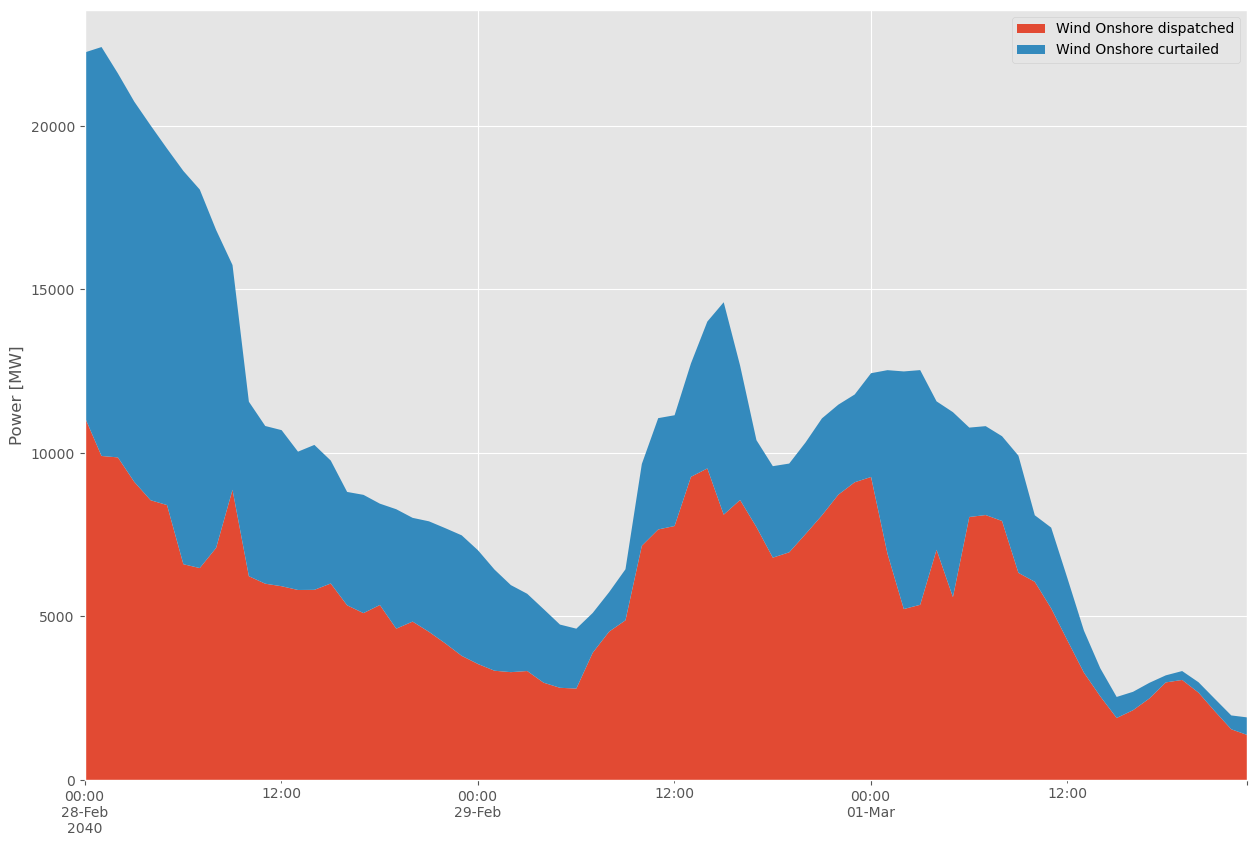

In [18]:
carrier = "Wind Onshore"

capacity = network.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier
p_df = pd.DataFrame({carrier + " available": p_available_by_carrier[carrier],
                     carrier + " dispatched": p_by_carrier[carrier],
                     carrier + " curtailed": p_curtailed_by_carrier[carrier]})

p_df[carrier + " capacity"] = capacity
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.] = 0.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, linewidth=0)
# p_df[[carrier + " available", carrier + " capacity"]].plot(ax=ax, linewidth=0)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.legend()